In [4]:
print("hello world")

hello world


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



In [6]:
df = pd.read_csv("../2EG.csv")

In [7]:
df.head()

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,SNASUC,ENESGR
0,424110070302,54.25,0.0,-0.866025,0.5,10,2010,0.006224,1.112
1,424110070345,30.81,0.0,-0.866025,0.5,10,2010,0.003535,0.632
2,424110070353,54.25,0.0,-0.866025,0.5,10,2010,0.006224,1.113
3,424110070370,30.81,0.0,-0.866025,0.5,10,2010,0.003535,0.632
4,424110070388,54.25,0.0,-0.866025,0.5,10,2010,0.006224,1.113


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124430 entries, 0 to 10124429
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ID_STANA    int64  
 1   POVRSINA    float64
 2   BR_OSOBA    float64
 3   MJESEC_sin  float64
 4   MJESEC_cos  float64
 5   MJESEC      int64  
 6   GODINA      int64  
 7   SNASUC      float64
 8   ENESGR      float64
dtypes: float64(6), int64(3)
memory usage: 695.2 MB


## Preprocesiranje


Dodajemo godisnje doba u skup.

In [9]:
def add_seasons(df):
    """
    Metoda za dodavanje sezone u skup.
    """
    # Definiramo mapiranje mjeseci u godisnja doba
    season_map = {
        12: 'Zima', 1: 'Zima', 2: 'Zima',
        3: 'Proljece', 4: 'Proljece', 5: 'Proljece',
        6: 'Ljeto', 7: 'Ljeto', 8: 'Ljeto',
        9: 'Jesen', 10: 'Jesen', 11: 'Jesen'
    }
    
    df['SEZONA'] = df['MJESEC'].map(season_map)
    df['SEZONA'] = df['SEZONA'].astype('category')
    return df

In [10]:
df = add_seasons(df)
df = df.drop(columns=['MJESEC_sin', 'MJESEC_cos'])

In [11]:
def encode_seasons_ordinal(df):
    """
    Metoda za ordinalno kodiranje kategoricke varijable SEZONA.
    """
    
    # Definiramo mapiranje
    ordinal_map = {
        'Zima': 1.0,
        'Jesen': 0.66,
        'Proljeće': 0.33,
        'Ljeto': 0.0
    }
    df['SEZONA_NUM'] = df['SEZONA'].map(ordinal_map)
    return df

In [12]:
df = encode_seasons_ordinal(df)

In [13]:
df = df[df['ENESGR'].notna() & (df['ENESGR'] != 0)]
df_F = df[df['ID_STANA']<40_000_000]
df = df[df['ID_STANA']>40_000_000]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8097721 entries, 0 to 10123905
Data columns (total 9 columns):
 #   Column      Dtype   
---  ------      -----   
 0   ID_STANA    int64   
 1   POVRSINA    float64 
 2   BR_OSOBA    float64 
 3   MJESEC      int64   
 4   GODINA      int64   
 5   SNASUC      float64 
 6   ENESGR      float64 
 7   SEZONA      category
 8   SEZONA_NUM  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 563.7 MB


In [15]:
df_F.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46744 entries, 75746 to 10020111
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID_STANA    46744 non-null  int64   
 1   POVRSINA    46692 non-null  float64 
 2   BR_OSOBA    2890 non-null   float64 
 3   MJESEC      46744 non-null  int64   
 4   GODINA      46744 non-null  int64   
 5   SNASUC      46711 non-null  float64 
 6   ENESGR      46744 non-null  float64 
 7   SEZONA      46744 non-null  category
 8   SEZONA_NUM  30153 non-null  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 3.3 MB


In [16]:
target = "ENESGR"

## Grafovi

### Provjera korelacije

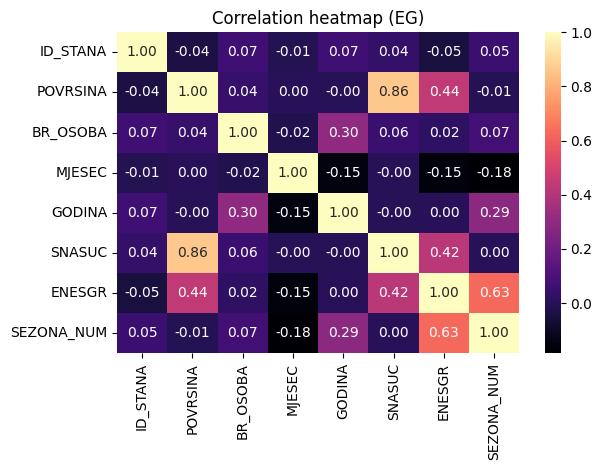

In [17]:
corr = df.corr(numeric_only=True)

#df_with_dummies = pd.get_dummies(df, columns=['SEZONA'], prefix='S')
#corr = df_with_dummies.corr(numeric_only=True)

ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")

plt.tight_layout()
plt.show()

## Trendovi podataka

In [18]:
def diagnose_features(data, features, target):
    """
    Metoda za graficki pregled trendova u podatcima.
    """
    num_features = len(features)
    rows = (num_features + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Crtamo podatke i trend
        sns.regplot(
            data=data, 
            x=col, 
            y=target, 
            ax=axes[i],
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red'},
            lowess=True # Lowess crta liniju koja prati lokalni trend (otkriva zakrivljenost)
        )
        axes[i].set_title(f'{target} vs {col}')
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # Brišemo prazne grafove ako ih ima
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [19]:
#diagnose_features(df, ['POVRSINA', 'BR_OSOBA', 'SEZONA_NUM', 'S_SNAGA'], 'ENESGR')

## Grupiranje

### Algoritam K-sredina

In [20]:
from sklearn.metrics import silhouette_score

def find_optimal_k(data, features, title, target=None):
    """
    Metoda za trazenje optimaknog broja grupa k nad podatcima i znacajkama
    """
    features = features.copy()
    if target is not None:
        features.append(target)
    
    X_sub = data[features].dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sub)
    
    inertia = []
    silhouette_avg = []
    K_range = range(2, 9)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertia.append(kmeans.inertia_)
        
        # Silhouette na uzorku zbog brzine ako je dataset velik
        # Ovo mozda maknuti -> presporo
        sample_size = min(len(X_scaled), 5000)
        # sample_size = len(X_scaled)
        idx = np.random.choice(len(X_scaled), sample_size, replace=False)
        current_silhouette = silhouette_score(X_scaled[idx], labels[idx])
        silhouette_avg.append(current_silhouette)
        print(f"{k:<5} | {current_silhouette:<15.4f}")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Broj klastera (k)')
    ax1.set_ylabel('Inertia (Lakat)', color='blue')
    ax1.plot(K_range, inertia, 'bo-')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score (Više je bolje)', color='red')
    ax2.plot(K_range, silhouette_avg, 'ro-')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Određivanje optimalnog k za: {title}')
    plt.show()

In [22]:
print(df.columns)

Index(['ID_STANA', 'POVRSINA', 'BR_OSOBA', 'MJESEC', 'GODINA', 'SNASUC',
       'ENESGR', 'SEZONA', 'SEZONA_NUM'],
      dtype='object')


2     | 0.5499         
3     | 0.4411         
4     | 0.4329         
5     | 0.4973         
6     | 0.4962         
7     | 0.4997         
8     | 0.5409         


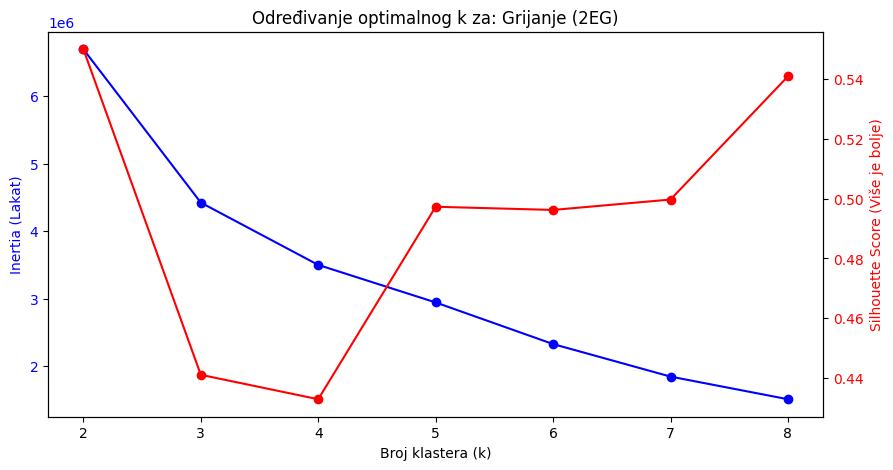

In [45]:
_features = ["POVRSINA","SEZONA_NUM"]
find_optimal_k(df, _features, "Grijanje (2EG)")

Najveci silhouette score ima grupiranje s k=3 grupe. Iz tog razloga dalje nastavljamo s tim grupiranjem.  

In [25]:
def perform_clustering(data, features, n_clusters=4, target=None):
    """ 
    Metoda za grupiranje podataka.
    """
    features = features.copy()
    if target is not None:
        features.append(target)
    df_sub = data[features].dropna().copy()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_sub)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_sub['cluster'] = kmeans.fit_predict(scaled_data)
    
    return df_sub['cluster']

In [46]:
df['cluster'] = perform_clustering(df, _features, 3)
print(f"Klasteri:\n{df['cluster'].value_counts()}")

Klasteri:
cluster
0.0    2720962
2.0    1928283
1.0    1035241
Name: count, dtype: int64


### Metode za 2D/37D prikaz grupa

In [27]:
def plot_clustering_2d(df, features, target=None):
    """
    Metoda za graficki prikaz grupa.
    """
    features = features.copy()
    if target is not None:
        features.append(target)
        
    if 'cluster' not in df.columns:
        print("Klasteri nisu pronađeni u DataFrame-u. Molimo pokrenite perform_clustering prvo.")

    # Izracun centroida 
    centroids = df.groupby('cluster')[features].mean().reset_index()
    
    plt.figure(figsize=(10, 7))
    
    sns.scatterplot(
        data=df, 
        x=features[0],
        y=features[1],
        hue='cluster', 
        palette='viridis', 
        s=50,             
        alpha=0.6,        
        edgecolor='w',    
        legend='full'     
    )
    
    # Crtanje centroida 
    sns.scatterplot(
        data=centroids, 
        x=features[0],
        y=features[1],
        marker='X',        
        s=250,             
        color='red',       
        edgecolor='black', 
        label='Centroidi'  
    )
    
    plt.title('Klasteri i Centroidi')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

In [28]:
from mpl_toolkits.mplot3d import Axes3D

def plot_clustering_3d(df, features, target=None):
    """
    Metoda za 3D graficki prikaz grupa
    """
    features = features.copy()
    if target is not None:
        features.append(target)
    if len(features) < 3:
        print("Za 3D prikaz su potrebne točno 3 znacajke u listi 'features'.")
        return

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Izračun centroida za 3 značajke
    centroids = df.groupby('cluster')[features].mean().reset_index()

    # Boje za klastere (korištenje viridis palete)
    scatter = ax.scatter(
        df[features[0]], 
        df[features[1]], 
        df[features[2]], 
        c=df['cluster'], 
        cmap='viridis', 
        s=40, 
        alpha=0.5, 
        edgecolor='w'
    )

    # Crtanje centroida
    ax.scatter(
        centroids[features[0]], 
        centroids[features[1]], 
        centroids[features[2]], 
        marker='X', 
        s=300, 
        color='red', 
        edgecolor='black', 
        label='Centroidi'
    )

    # Postavljanje labela
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    ax.set_title('3D Prikaz Klastera i Centroida')

    # Dodavanje legende za klastere
    legend1 = ax.legend(*scatter.legend_elements(), title="Klasteri", loc="upper left")
    ax.add_artist(legend1)
    ax.legend(loc="upper right")

    plt.show()

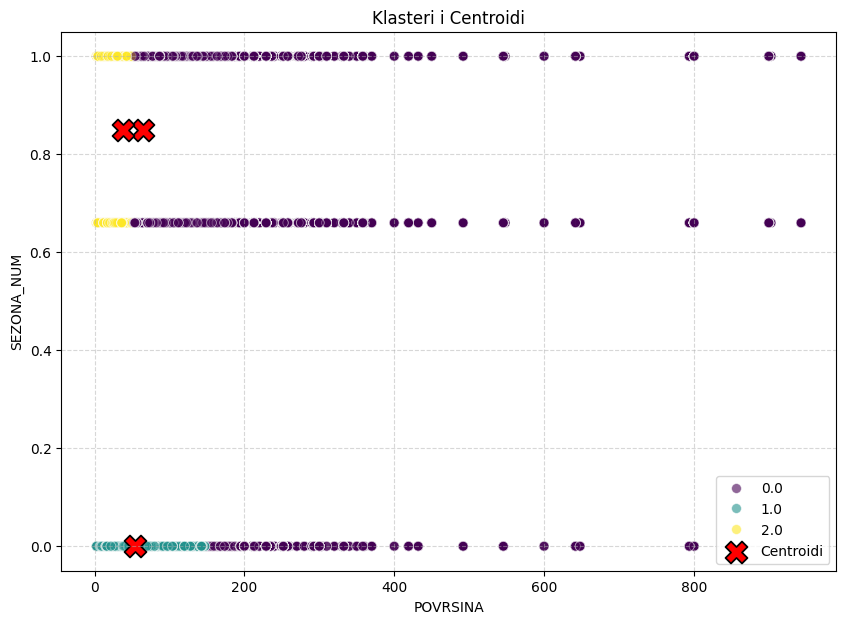

In [ ]:
plot_clustering_2d(df, _features)
# plot_clustering_3d(df, _features + ["ENESGR"])
#plot_clustering_3d(df, _features)

In [34]:
def analyze_clusters(data, features, target=None):
    """
    Racuna prosjek i standardnu devijaciju za zadane znacajke po klasterima.
    """
    cols_to_analyze = features.copy()
    if target:
        cols_to_analyze.append(target)
    
    # Grupiranje po klasteru i racunanje agregacija
    analysis = data.groupby('cluster')[cols_to_analyze].agg(['mean', 'std'])
    
    analysis.columns = [f"{col}_{stat}" for col, stat in analysis.columns]
    
    print("--- Analiza klastera (Prosjek i Std Dev) ---")
    return analysis

In [47]:
cluster_stats = analyze_clusters(df, _features, target='ENESGR')
display(cluster_stats)

--- Analiza klastera (Prosjek i Std Dev) ---


,POVRSINA_mean,POVRSINA_std,SEZONA_NUM_mean,SEZONA_NUM_std,ENESGR_mean,ENESGR_std
cluster,,,,,,
0.0,65.168239,17.357708,0.849292,0.170046,1.498650,0.813124
1.0,53.826039,16.974985,0.000000,0.000000,0.224193,0.086135
2.0,38.018407,7.991826,0.850254,0.168789,0.898712,0.480215


## Linearni modeli

In [36]:
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

def detect_outliers_regression(data, features, target):
    """
    Metoda za odredivanje outliera na temelju linearne regresije.
    """
    df_reg = data.copy().dropna(subset=features + [target])
    
    # 1. Treniranje modela
    X = df_reg[features]
    y = df_reg[target]
    
    model = LinearRegression()
    model.fit(X, y)
    
    # 2. Predvidanje
    df_reg['prediction'] = model.predict(X)
    df_reg['residual'] = df_reg[target] - df_reg['prediction']
    
    # 3. Izracun standardne devijacije reziduala (sigma)
    sigma = np.std(df_reg['residual'])
    
    # Racunamo Z-score za detekciju
    df_reg['z_score'] = zscore(df_reg['residual'])
    
    # Definiramo outliere (izvan +/- 3 sigme)
    outliers = df_reg[df_reg['z_score'] > 3] 
    normals = df_reg[df_reg['z_score'] <= 3]
    
    print(f"Pronadeno {len(outliers)} ekstrema od {len(df_reg)} zapisa (Sigma={sigma:.2f}).")
    
    plt.figure(figsize=(12, 8))
    plt.scatter(normals['prediction'], normals[target], 
                c='blue', alpha=0.3, s=20, label='Normalna potrosnja')
    plt.scatter(outliers['prediction'], outliers[target], 
                c='red', alpha=0.9, s=50, edgecolors='black', label='Outlieri (>3σ)')
    line_x = np.linspace(df_reg['prediction'].min(), df_reg['prediction'].max(), 100)
    plt.plot(line_x, line_x, color='black', linestyle='--', linewidth=2, label='Idealno predvidanje')
    plt.fill_between(line_x, 
                     line_x - 3*sigma, 
                     line_x + 3*sigma, 
                     color='green', alpha=0.15, label='Zona tolerancije (±3σ)')
    
    plt.xlabel(f'Ocekivana potrošnja - Model ({target})')
    plt.ylabel(f'Stvarna potrošnja ({target})')
    plt.title(f'Detekcija Outliera: Stvarno vs. Očekivano\n(Varijable: {", ".join(features)})')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()
    
    return outliers.sort_values(by='z_score', ascending=False)

Pronadeno 28932 ekstrema od 5684486 zapisa (Sigma=0.50).


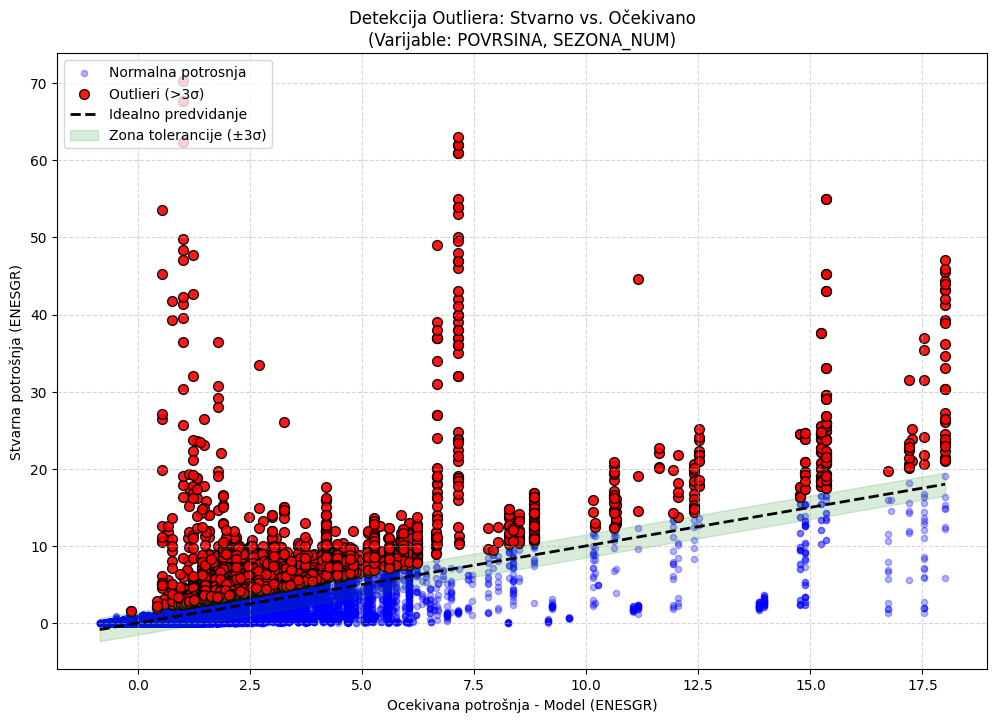

In [48]:
outliers = detect_outliers_regression(df, _features, 'ENESGR')

## Regresija po grupama


In [38]:
def perform_cluster_regression(df, features, target, trim_pct=0.025):
    """
    Metoda za regresiju po klasterima + subplot po klasteru
    trim_pct: postotak za izbacivanje ekstremnih y vrijednosti (npr. 0.01 = 1%)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression

    df_res = df.copy()
    
    df_res['prediction'] = np.nan
    df_res['residual'] = np.nan
    df_res['z_score_local'] = np.nan
    
    clusters = sorted(df_res['cluster'].unique())
    n_clusters = len(clusters)
    
    # Layout (max 3 po redu)
    n_cols = min(3, n_clusters)
    n_rows = int(np.ceil(n_clusters / n_cols))
    
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(5 * n_cols, 4 * n_rows),
        squeeze=False, sharex=False, sharey=False
    )
    
    print(f"{'Klaster':<10} | {'Prosjek':<12} | {'Lokalna Sigma':<15}")
    print("-" * 45)
    
    for idx, cl in enumerate(clusters):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        mask = df_res['cluster'] == cl
        subset = df_res[mask]
        
        if len(subset) < 2:
            ax.set_visible(False)
            continue
        
        X = subset[features]
        y = subset[target]

        # --- TRIM po y (1% dolje i 1% gore po default) ---
        q_low, q_high = y.quantile([trim_pct, 1 - trim_pct])
        trim_mask = (y >= q_low) & (y <= q_high)
        
        X_trim = X[trim_mask]
        y_trim = y[trim_mask]
        
        if len(y_trim) < 2:
            ax.set_visible(False)
            continue
        
        # Treniranje regresije na trimmed podacima
        model = LinearRegression()
        model.fit(X_trim, y_trim)
        
        preds = model.predict(X_trim)
        resids = y_trim - preds
        local_sigma = np.std(resids)
        
        # --- Ispravan upis u df_res (samo za trimmed podatke) ---
        final_mask = mask & trim_mask.reindex(df_res.index, fill_value=False)
        df_res.loc[final_mask, 'prediction'] = preds
        df_res.loc[final_mask, 'residual'] = resids
        df_res.loc[final_mask, 'z_score_local'] = (
            resids / local_sigma if local_sigma > 0 else 0
        )
        
        print(f"{cl:<10} | {y_trim.mean():<12.2f} | {local_sigma:<15.2f}")
        
        # --- PLOT PO KLASTERU ---
        ax.scatter(
            preds, y_trim,
            alpha=0.6,
            s=30
        )
        
        # Idealna linija y = x
        x_min = min(preds.min(), y_trim.min())
        x_max = max(preds.max(), y_trim.max())
        x_line = np.linspace(x_min, x_max, 100)
        
        ax.plot(
            x_line, x_line,
            linestyle='--',
            linewidth=2
        )
        
        # ±3σ zona
        if local_sigma > 0:
            ax.fill_between(
                x_line,
                x_line - 3 * local_sigma,
                x_line + 3 * local_sigma,
                alpha=0.15
            )
        
        # Prisilno autoscale samo za ovaj ax
        ax.relim()
        ax.autoscale_view()
        
        ax.set_title(f'Klaster {cl}')
        ax.set_xlabel('Predikcija')
        ax.set_ylabel('Stvarno')
        ax.grid(True, linestyle='--', alpha=0.4)
    
    # Sakrij prazne subplotove
    for i in range(n_clusters, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Označavanje outliera po lokalnom z-scoreu
    df_res['is_outlier'] = df_res['z_score_local'].abs() > 3
    
    return df_res


Klaster    | Prosjek      | Lokalna Sigma  
---------------------------------------------
0.0        | 1.47         | 0.50           
2.0        | 0.89         | 0.30           
1.0        | 0.22         | 0.05           


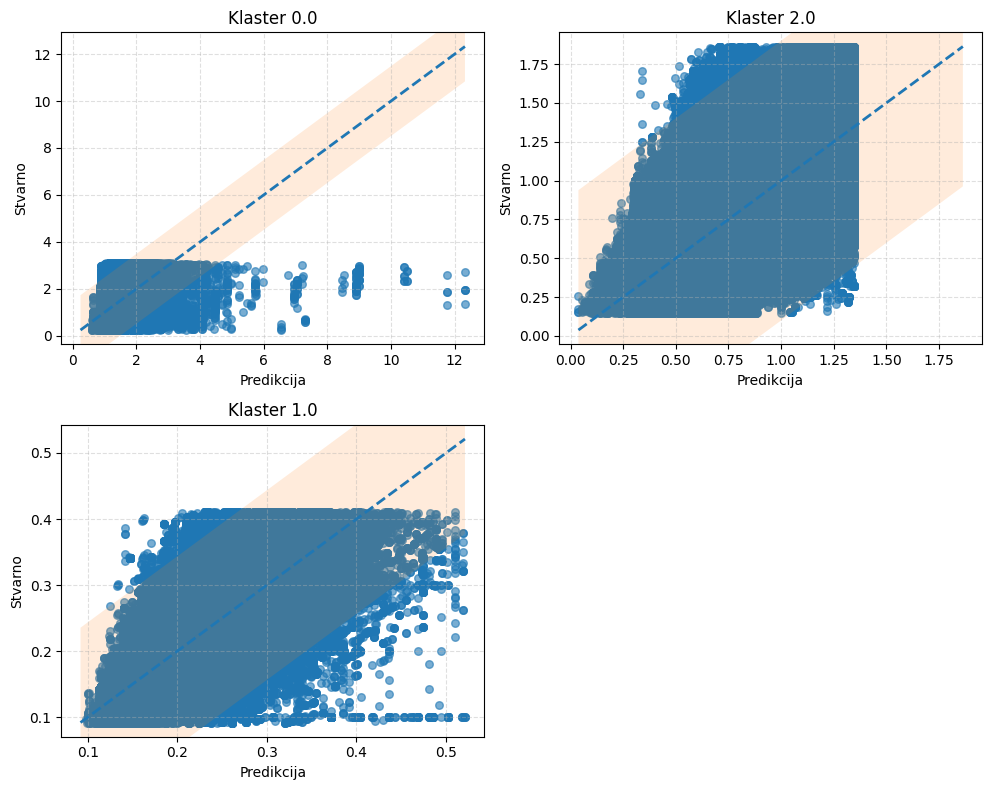

In [ ]:
df_final = perform_cluster_regression(df, _features, 'ENESGR')

### Odvajanje na 4 skupa za svako godišnje doba

In [50]:
df_WIN = df[df['SEZONA']=="Zima"]
df_SUM = df[df['SEZONA']=="Ljeto"]
df_REM = df[(df['SEZONA'] == "Proljece") | (df['SEZONA'] == "Jesen")]

In [51]:
df_WIN.info()
df_SUM.info()
df_REM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2596988 entries, 195236 to 9881609
Data columns (total 10 columns):
 #   Column      Dtype   
---  ------      -----   
 0   ID_STANA    int64   
 1   POVRSINA    float64 
 2   BR_OSOBA    float64 
 3   MJESEC      int64   
 4   GODINA      int64   
 5   SNASUC      float64 
 6   ENESGR      float64 
 7   SEZONA      category
 8   SEZONA_NUM  float64 
 9   cluster     float64 
dtypes: category(1), float64(6), int64(3)
memory usage: 200.6 MB
<class 'pandas.core.frame.DataFrame'>
Index: 1036840 entries, 778525 to 10123905
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   ID_STANA    1036840 non-null  int64   
 1   POVRSINA    1036840 non-null  float64 
 2   BR_OSOBA    958926 non-null   float64 
 3   MJESEC      1036840 non-null  int64   
 4   GODINA      1036840 non-null  int64   
 5   SNASUC      1036840 non-null  float64 
 6   ENESGR      1036840 non-null  float64 


## Zima

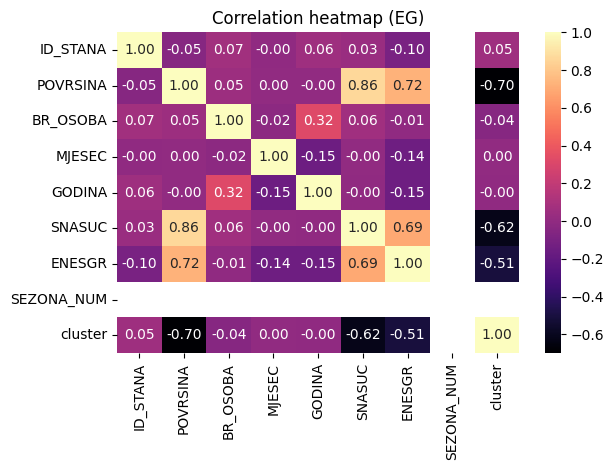

In [52]:
corr = df_WIN.corr(numeric_only=True)
ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")
plt.tight_layout()
plt.show()

2     | 0.4554         
3     | 0.4311         
4     | 0.4260         
5     | 0.3849         
6     | 0.3723         
7     | 0.3769         
8     | 0.3559         


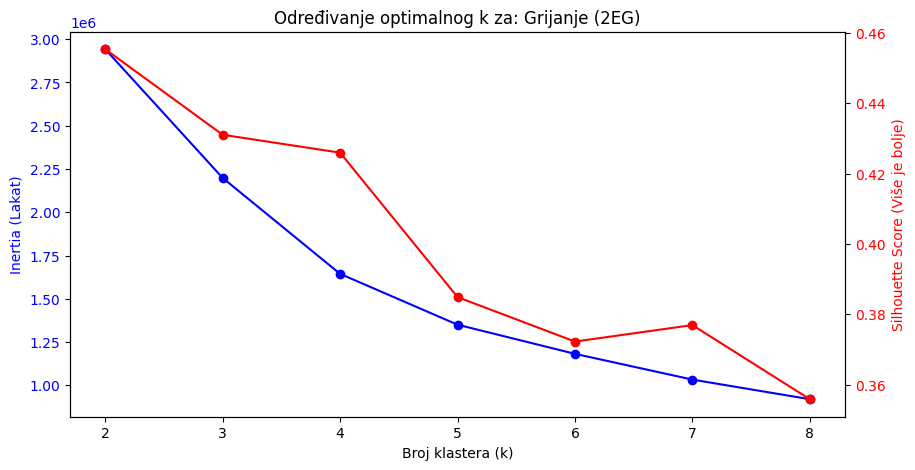

In [61]:
_features = ['POVRSINA']
find_optimal_k(df_WIN, _features, "Grijanje (2EG)", target)

In [62]:
df_WIN['cluster'] = perform_clustering(df_WIN, _features, 3)
print(f"Klasteri:\n{df_WIN['cluster'].value_counts()}")

Klasteri:
cluster
1    1269156
0     855264
2     472568
Name: count, dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_25100\1778012100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WIN['cluster'] = perform_clustering(df_WIN, _features, 3)


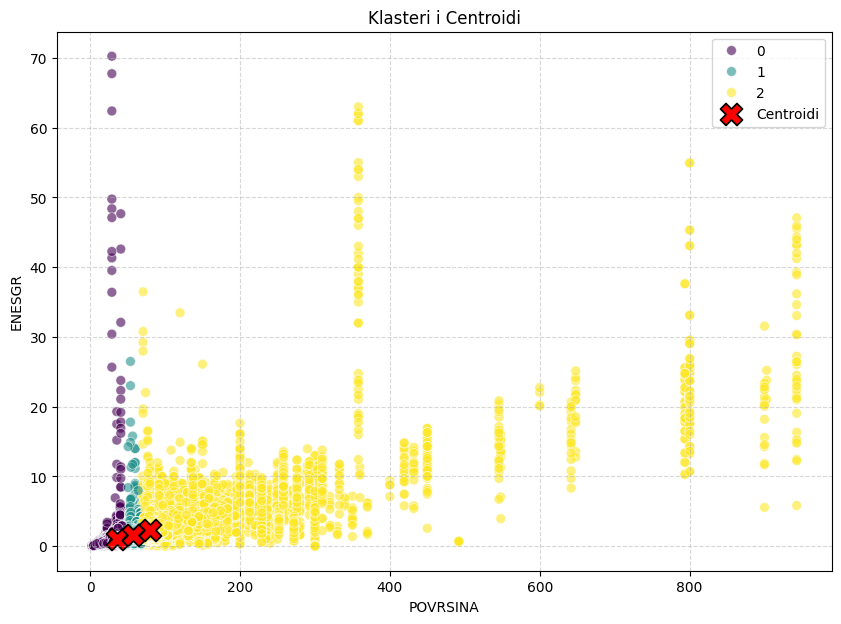

In [63]:
# plot_clustering_2d(df_WIN, _features)
plot_clustering_2d(df_WIN, _features, target)
# plot_clustering_3d(df_WIN, _features + ["ENESGR"])

Pronadeno 9491 ekstrema od 2596988 zapisa (Sigma=0.51).


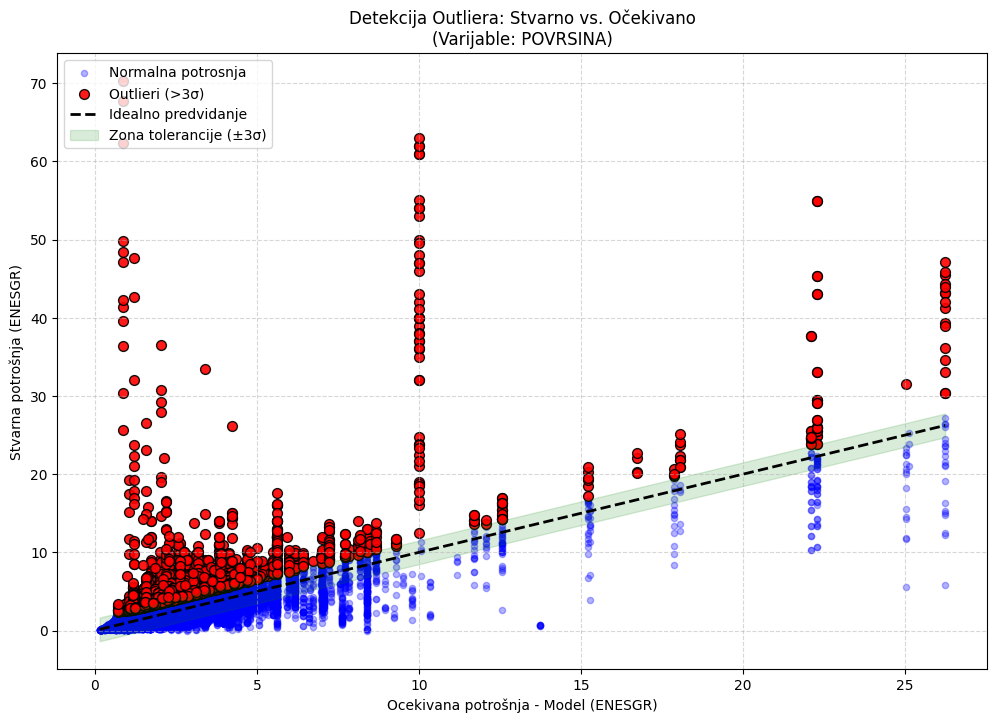

In [64]:
outliers = detect_outliers_regression(df_WIN, _features, 'ENESGR')

Klaster    | Prosjek      | Lokalna Sigma  
---------------------------------------------
0          | 1.05         | 0.28           
1          | 1.64         | 0.42           
2          | 2.27         | 0.61           


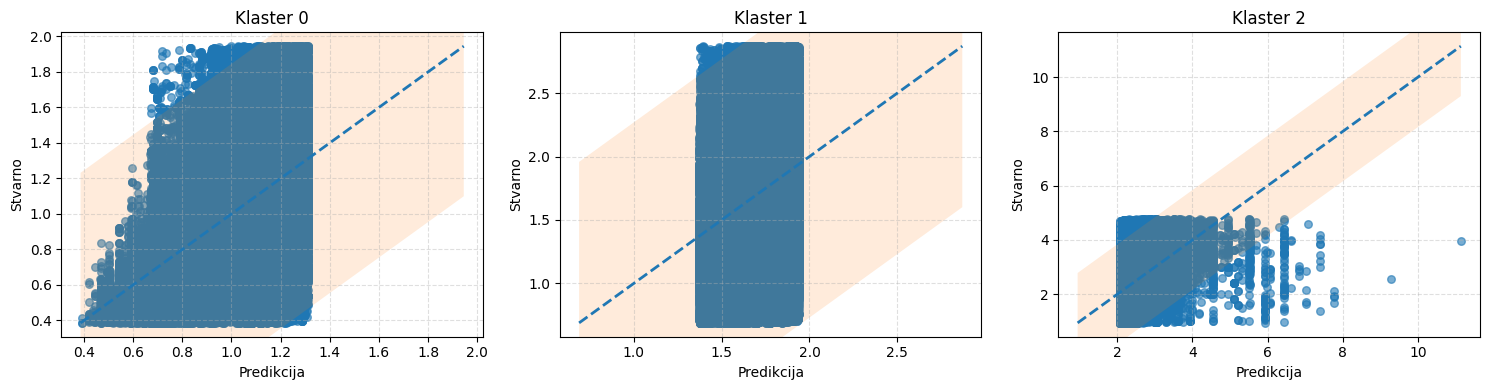

In [65]:
df_final_WIN = perform_cluster_regression(df_WIN, _features, target, 0.01)

## Ljeto

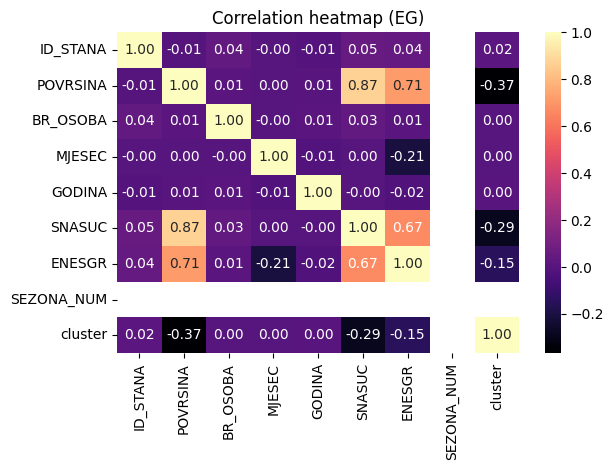

In [66]:
corr = df_SUM.corr(numeric_only=True)
ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")
plt.tight_layout()
plt.show()

2     | 0.4595         
3     | 0.4511         
4     | 0.4412         
5     | 0.4178         
6     | 0.3711         
7     | 0.3836         
8     | 0.3510         


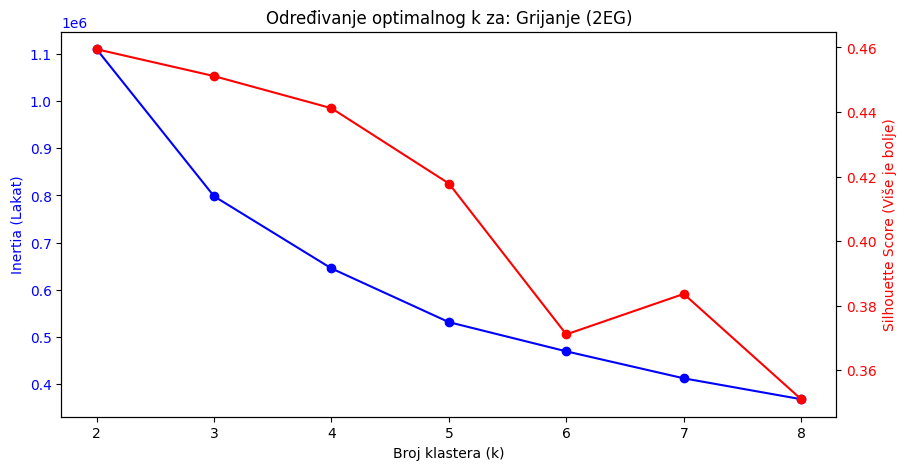

In [68]:
_features = ['POVRSINA']
find_optimal_k(df_SUM, _features, "Grijanje (2EG)", target)

In [69]:
df_SUM['cluster'] = perform_clustering(df_SUM, _features, 3)
print(f"Klasteri:\n{df_SUM['cluster'].value_counts()}")

Klasteri:
cluster
2    493444
1    340627
0    202769
Name: count, dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_25100\3707262451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SUM['cluster'] = perform_clustering(df_SUM, _features, 3)


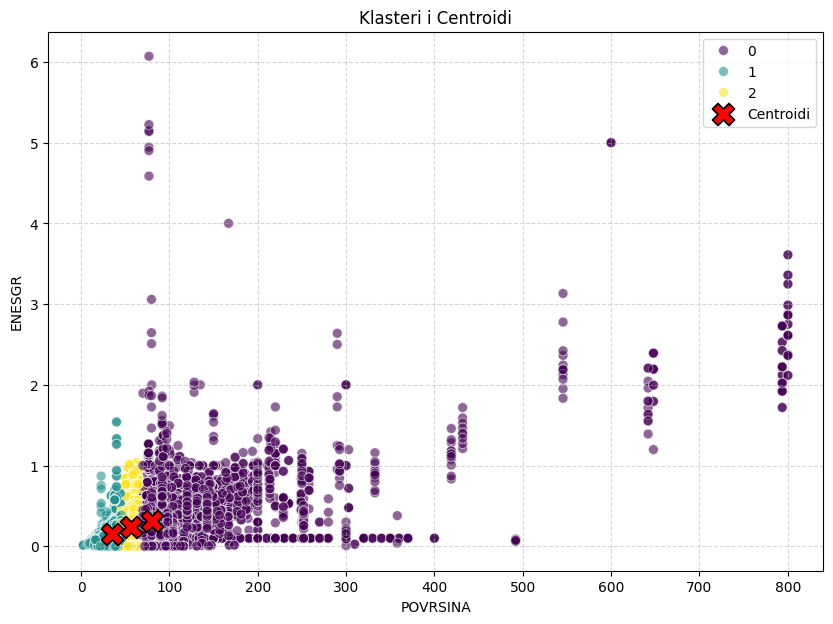

In [70]:
# plot_clustering_2d(df_WIN, _features)
plot_clustering_2d(df_SUM, _features, target)
# plot_clustering_3d(df_SUM, _features, target)

Pronadeno 6203 ekstrema od 1036840 zapisa (Sigma=0.06).


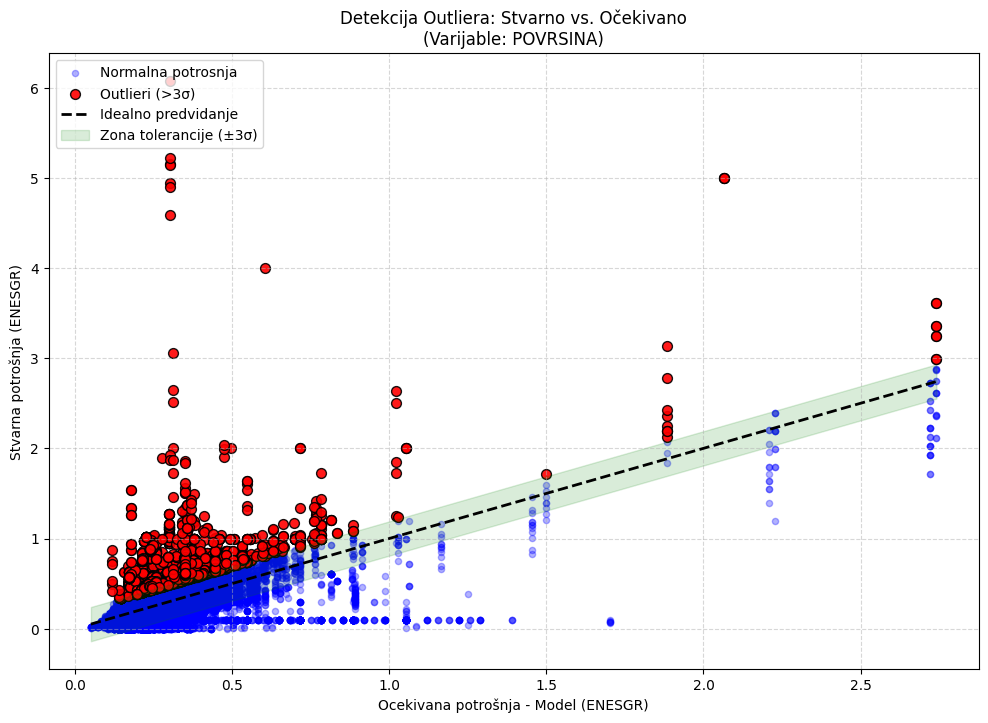

In [71]:
outliers = detect_outliers_regression(df_SUM, _features, target)

Klaster    | Prosjek      | Lokalna Sigma  
---------------------------------------------
0          | 0.31         | 0.07           
1          | 0.15         | 0.03           
2          | 0.24         | 0.05           


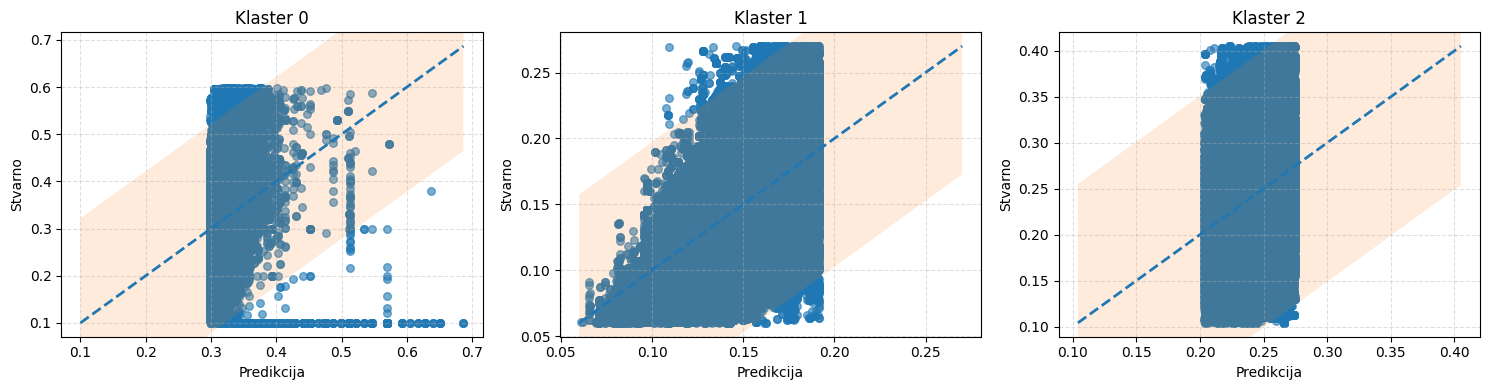

In [72]:
df_final_SUM = perform_cluster_regression(df_SUM, _features, target, 0.01)

## Jesen i proljeće

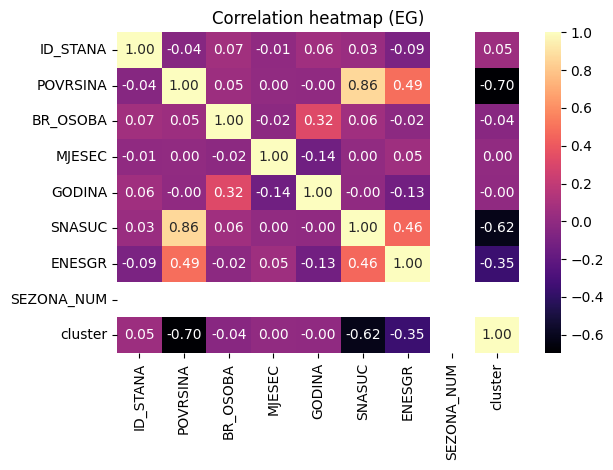

In [73]:
corr = df_REM.corr(numeric_only=True)
ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")
plt.tight_layout()
plt.show()

2     | 0.4510         
3     | 0.4341         
4     | 0.4558         
5     | 0.3988         
6     | 0.3688         
7     | 0.3815         
8     | 0.3475         


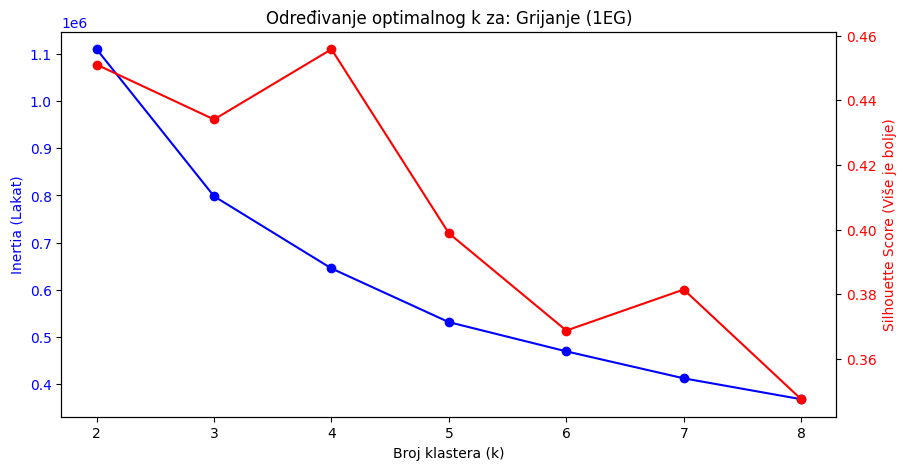

In [74]:
_features = ['POVRSINA']
find_optimal_k(df_SUM, _features, "Grijanje (1EG)", target)

In [76]:
df_REM['cluster'] = perform_clustering(df_REM, _features, 3)
print(f"Klasteri:\n{df_REM['cluster'].value_counts()}")

Klasteri:
cluster
1    2184322
0    1468565
2     811006
Name: count, dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_25100\3180200200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_REM['cluster'] = perform_clustering(df_REM, _features, 3)


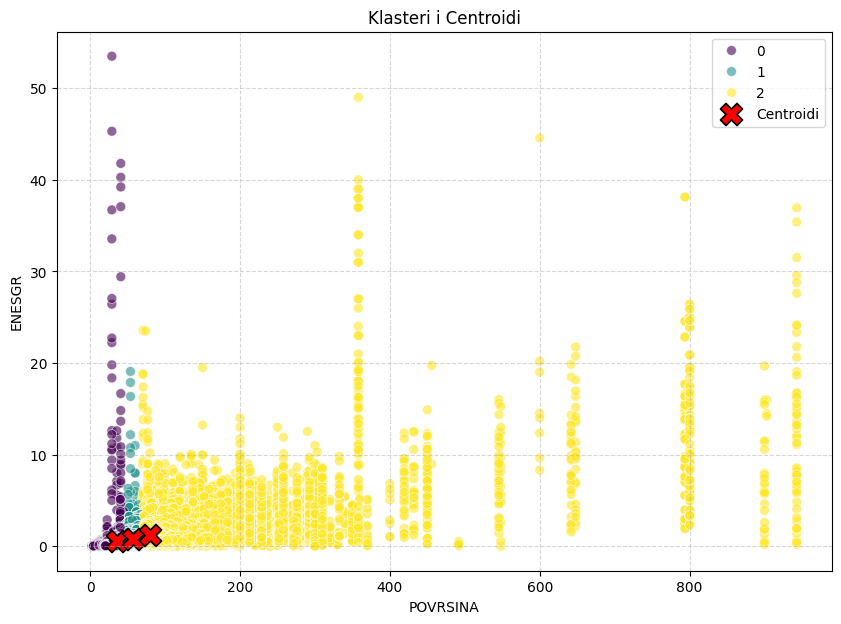

In [78]:
# plot_clustering_2d(df_WIN, _features)
plot_clustering_2d(df_REM, _features, target)
# plot_clustering_3d(df_SUM, _features, target)

Pronadeno 29078 ekstrema od 4463893 zapisa (Sigma=0.48).


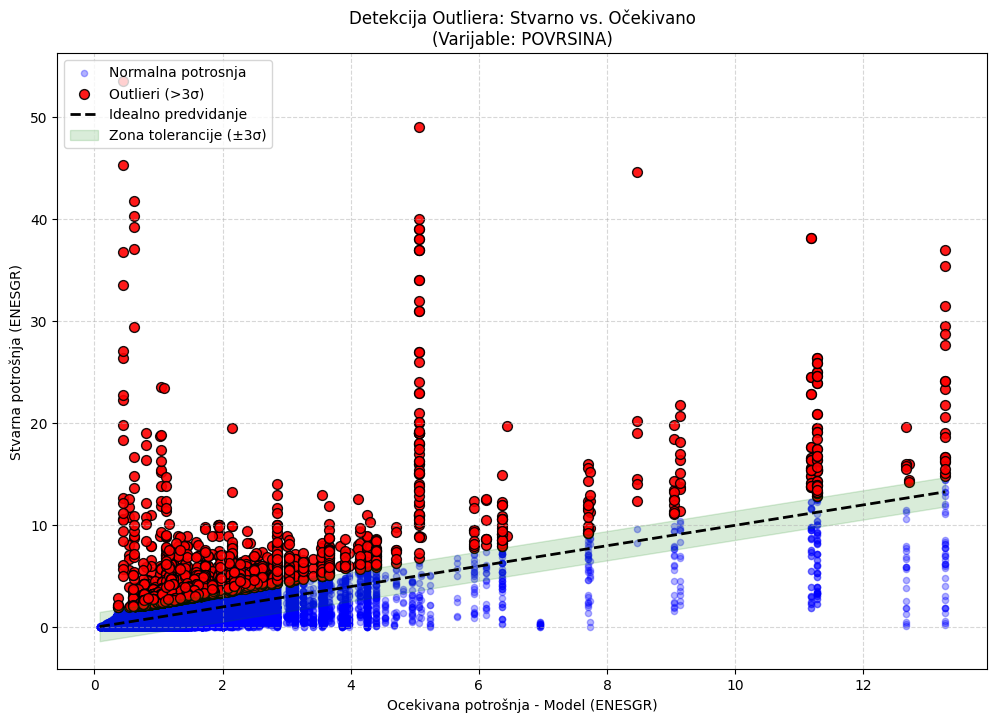

In [80]:
outliers = detect_outliers_regression(df_REM, _features, target)

Klaster    | Prosjek      | Lokalna Sigma  
---------------------------------------------
0          | 0.53         | 0.28           
1          | 0.83         | 0.44           
2          | 1.16         | 0.62           


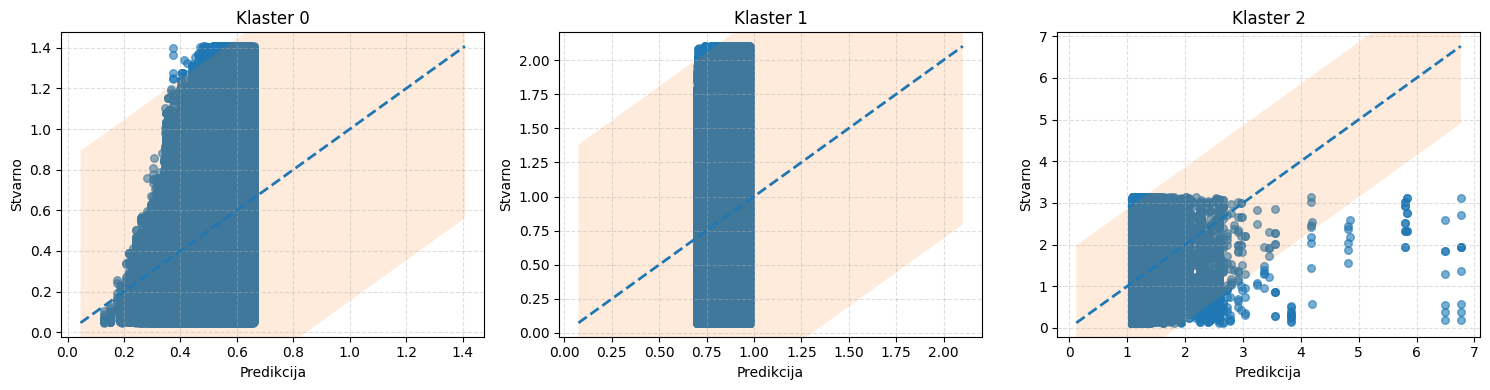

In [81]:
df_final_REM = perform_cluster_regression(df_REM, _features, target, 0.01)